**Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

**Set Seed for Reproducibility**

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark=False

set_seed()

**Set Device (GPU)**

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device:{device} " )

Using device:cuda 


**Setting up the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/EuroSAT_RGB.zip'
extract_path = '/content/EuroSAT_RGB'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
for folder_name in os.listdir(extract_path):
  print(folder_name)

EuroSAT_RGB


In [ ]:

print(os.listdir("/content"))

['.config', 'drive', 'EuroSAT_RGB', 'sample_data']


In [ ]:
root_dir = "/content/EuroSAT_RGB/EuroSAT_RGB"
print(os.listdir(root_dir))


['SeaLake', 'AnnualCrop', 'PermanentCrop', 'Industrial', 'HerbaceousVegetation', 'Forest', 'River', 'Residential', 'Highway', 'Pasture']


**CREATING A DATAFRAME**

In [ ]:

# Create list of image paths and their labels
image_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_folder = os.path.join(root_dir, class_name)

    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Show top few rows
df.head()


,image_path,label
0,/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake/SeaLa...,SeaLake
1,/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake/SeaLa...,SeaLake
2,/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake/SeaLa...,SeaLake
3,/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake/SeaLa...,SeaLake
4,/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake/SeaLa...,SeaLake


In [ ]:
df.tail()

,image_path,label
26995,/content/EuroSAT_RGB/EuroSAT_RGB/Pasture/Pastu...,Pasture
26996,/content/EuroSAT_RGB/EuroSAT_RGB/Pasture/Pastu...,Pasture
26997,/content/EuroSAT_RGB/EuroSAT_RGB/Pasture/Pastu...,Pasture
26998,/content/EuroSAT_RGB/EuroSAT_RGB/Pasture/Pastu...,Pasture
26999,/content/EuroSAT_RGB/EuroSAT_RGB/Pasture/Pastu...,Pasture


In [ ]:
df.shape

(27000, 2)

**VSUALIZING SOME DATA**

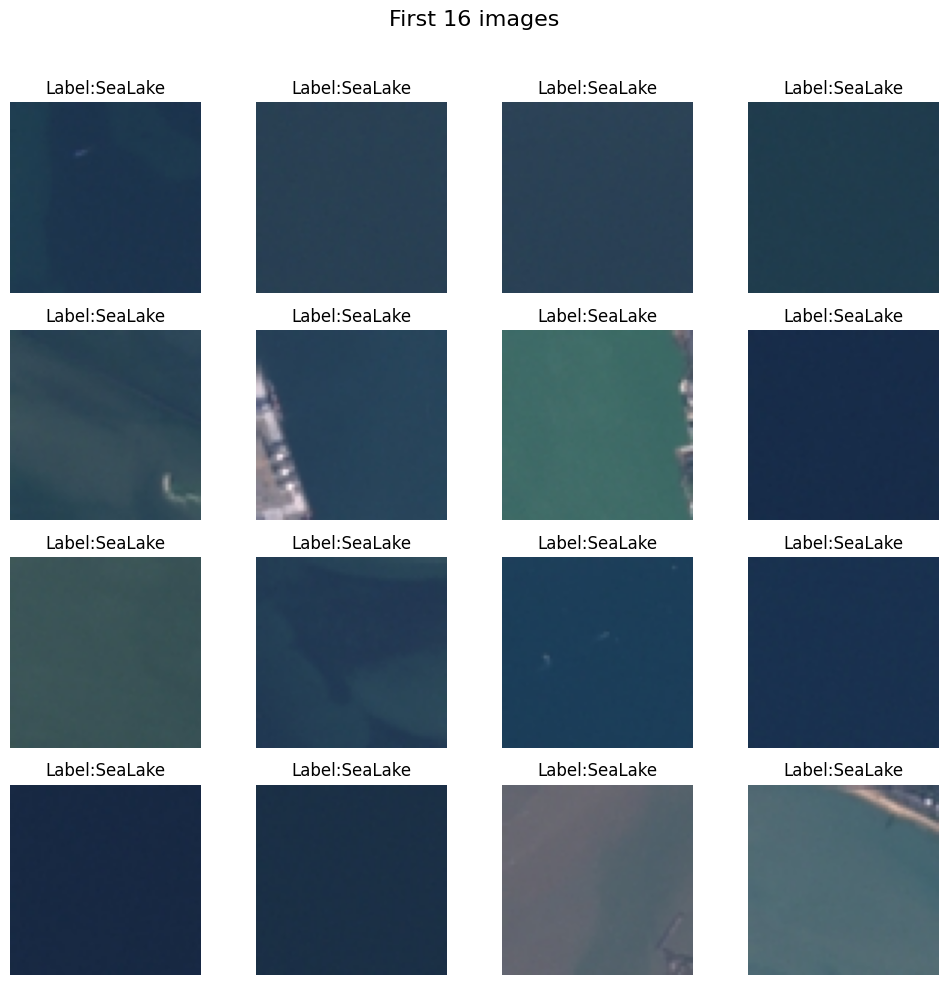

In [ ]:
#creating a 4*4 grid of images
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images", fontsize=16)

for i,ax in enumerate(axes.flat):
  img_path = df.iloc[i, 0]
  img = Image.open(img_path)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(f"Label:{df.iloc[i,1]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

**CHECKING FOR EMPTY VALUES**


In [ ]:
df.isnull().sum()

,0
image_path,0
label,0


**DEFINING X AND Y**

In [ ]:
X=df.iloc[:,0].values
y=df.iloc[:,1].values

**LABEL ENCODING**

In [ ]:
le=LabelEncoder()
y=le.fit_transform(y)

In [ ]:
print(le.classes_)


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


**TRAIN TEST SPLIT**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

**CUSTOM DATASET CLASS**

In [ ]:
train_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    )
])

test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    )
])

class CustomDataset(Dataset):
  def __init__(self,image_paths,labels,transform=None):
    self.image_paths=image_paths
    self.labels=labels
    self.transform=transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self,index):
    img=Image.open(self.image_paths[index]).convert('RGB')

    if self.transform:
      img=self.transform(img)
    else:
      img=transforms.ToTensor()(img)


    label=torch.tensor(self.labels[index],dtype=torch.long)

    return img, label

**CustomDataset object for train and test**

In [ ]:
train_dataset=CustomDataset(X_train,y_train,transform=train_transform)
test_dataset=CustomDataset(X_test,y_test,transform=test_transform)

**DATALOADER FOR TRAIN AND TEST**

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=False)

**SAMPLE IMAGE TO INPUT SIZE**

In [ ]:
sample_img, _ = train_dataset[0]
input_size = sample_img.numel()
print(f"Input size: {input_size}")

Input size: 12288


**DEFINING THE MODEL**

In [ ]:
class MyNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features=nn.Sequential(

        #1st Convolution Block
        nn.Conv2d(3,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        #2nd Convolution Block
        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2),


        #3rd Convolution Block
        nn.Conv2d(64,128,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2,stride=2)

    )
    self.classifier=nn.Sequential(
        nn.Flatten(),  #flatten layer
        nn.Linear(128*8*8,128), #hidden layer
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),   #hidden layer 2
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)     #output layer


    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)

    return x


In [ ]:
learning_rate=0.001
epochs=100

**INSTANTIATE THE MODEL**

In [ ]:
model=MyNN()

model.to(device)

MyNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, in

In [ ]:
#Loss Function
criterion=nn.CrossEntropyLoss()

#Optimizer
optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)

**TRAINING LOOP**

In [ ]:
train_losses = []
test_accuracies = []

for epoch in range(epochs):

  total_epoch_loss=0

  model.train()

  for batch_features, batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)

    outputs=model(batch_features)   #forward pass

    loss=criterion(outputs,batch_labels)  #Compute loss

    optimizer.zero_grad()   #Reset gradients
    loss.backward()         #Backward pass

    optimizer.step()        #Update weights

    total_epoch_loss+=loss.item()    #Accumulate loss

  avg_loss=total_epoch_loss/len(train_loader)
  train_losses.append(avg_loss)



  #FOR PLOTTING LOSS AND ACCURACY
  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)


      outputs = model(batch_features)  #Forward pass
      _, predicted = torch.max(outputs, 1)  #Getting predicted class


      total += batch_labels.size(0)     #Total samples
      correct += (predicted == batch_labels).sum().item()  #Correct predictions

  accuracy = correct / total #Accuracy for this epoch
  test_accuracies.append(accuracy)




  print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch: 1, Loss: 1.3608, Accuracy: 0.6713
Epoch: 2, Loss: 0.9490, Accuracy: 0.7874
Epoch: 3, Loss: 0.8445, Accuracy: 0.8152
Epoch: 4, Loss: 0.7282, Accuracy: 0.7007
Epoch: 5, Loss: 0.6733, Accuracy: 0.7578
Epoch: 6, Loss: 0.6148, Accuracy: 0.8128
Epoch: 7, Loss: 0.5503, Accuracy: 0.7778
Epoch: 8, Loss: 0.5109, Accuracy: 0.8663
Epoch: 9, Loss: 0.4827, Accuracy: 0.8774
Epoch: 10, Loss: 0.4693, Accuracy: 0.9076
Epoch: 11, Loss: 0.4361, Accuracy: 0.9091
Epoch: 12, Loss: 0.4088, Accuracy: 0.8846
Epoch: 13, Loss: 0.3885, Accuracy: 0.9131
Epoch: 14, Loss: 0.3869, Accuracy: 0.8533
Epoch: 15, Loss: 0.3620, Accuracy: 0.8976
Epoch: 16, Loss: 0.3394, Accuracy: 0.9139
Epoch: 17, Loss: 0.3338, Accuracy: 0.8726
Epoch: 18, Loss: 0.3258, Accuracy: 0.8933
Epoch: 19, Loss: 0.3170, Accuracy: 0.9178
Epoch: 20, Loss: 0.3144, Accuracy: 0.9272
Epoch: 21, Loss: 0.2981, Accuracy: 0.9322
Epoch: 22, Loss: 0.2868, Accuracy: 0.9211
Epoch: 23, Loss: 0.2921, Accuracy: 0.9215
Epoch: 24, Loss: 0.2833, Accuracy: 0.9194
E

**SAVING THE MODEL**

In [ ]:
torch.save(model.state_dict(), 'eurosat_cnn.pth')

In [ ]:
model = MyNN()
model.load_state_dict(torch.load('eurosat_cnn.pth'))
model.to(device)
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, in

**MODEL EVALUATION ON TEST DATA**

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100*correct / total:.2f}")

Test Accuracy: 95.22


**MODEL EVALUATION ON TRAIN DATA**

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"Train Accuracy: {100*correct / total:.2f}")

Train Accuracy: 97.61


**MAKING PREDICTION ON SINGLE EUROSAT IMAGE**

Predicted Class index: 6
Predicted class label: PermanentCrop


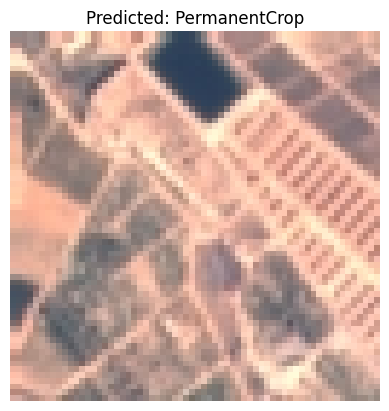

In [ ]:
# 1. Class labels
class_names=[
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'

]

# 2. Transform
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5,0.5,0.5],
        std=[0.5,0.5,0.5]
    )
])

# 3. Load and preprocess image
image_path="/content/EuroSAT_RGB/EuroSAT_RGB/PermanentCrop/PermanentCrop_98.jpg" # Corrected image path
image=Image.open(image_path).convert('RGB')
input_tensor=transform(image).unsqueeze(0)
input_tensor=input_tensor.to(device)



#Predict:
model.eval()
with torch.no_grad():
  outputs=model(input_tensor)
  predicted_class=torch.argmax(outputs,dim=1).item()


#Output result:
print(f"Predicted Class index: {predicted_class}")
print(f"Predicted class label: {class_names[predicted_class]}")



plt.imshow(image)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

In [ ]:
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


**PLOTTING LOSS AND ACCURACY**

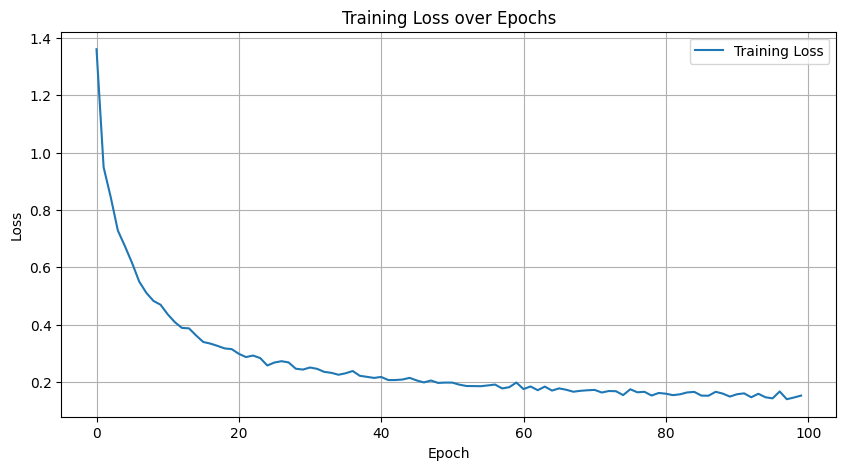

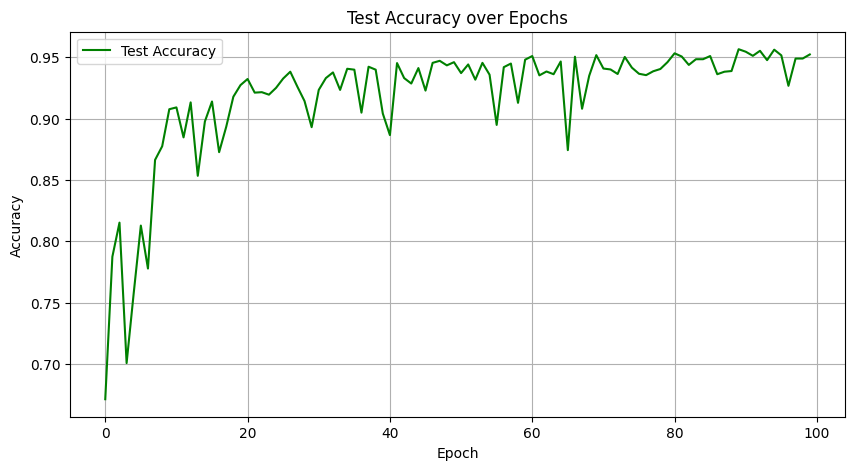

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()


**CONFUSION MATRIX AND CLASSIFICATION REPORT**

Classification report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.95      0.93       600
              Forest       0.96      1.00      0.98       600
HerbaceousVegetation       0.93      0.92      0.92       600
             Highway       0.96      0.94      0.95       500
          Industrial       0.98      0.96      0.97       500
             Pasture       0.95      0.94      0.94       400
       PermanentCrop       0.94      0.86      0.90       500
         Residential       0.96      0.99      0.98       600
               River       0.94      0.94      0.94       500
             SeaLake       0.99      0.99      0.99       600

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400



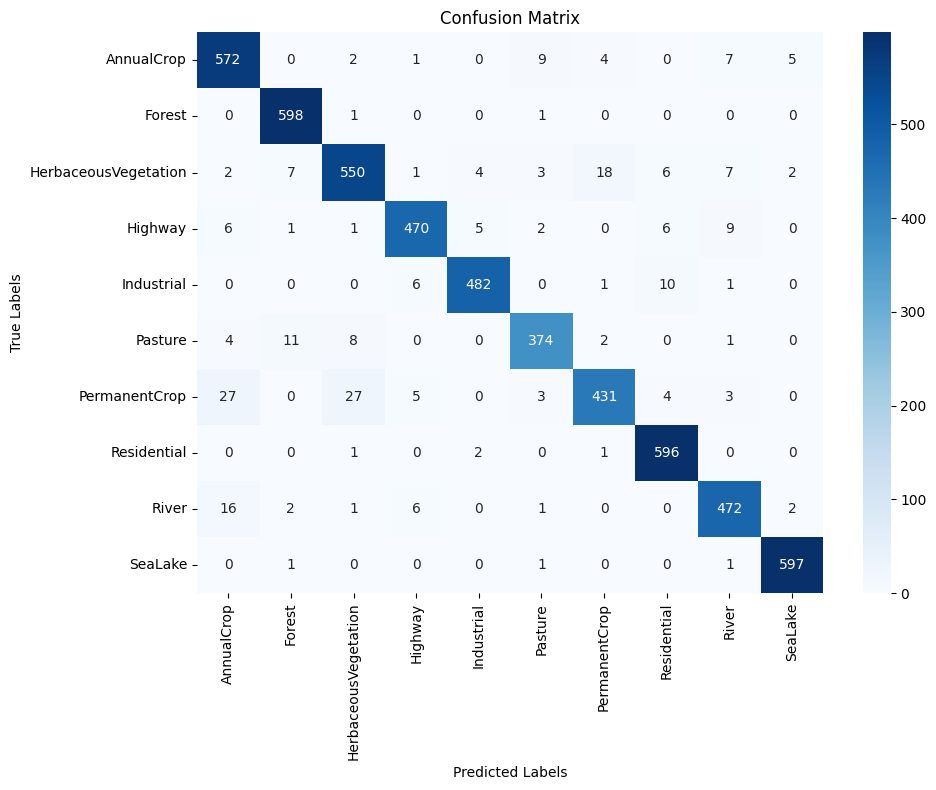

In [ ]:
model.eval()


class_names=le.classes_

all_preds=[]
all_labels=[]

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs=inputs.to(device)
    labels=labels.to(device)

    outputs=model(inputs)
    _,preds=torch.max(outputs,1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())


# Convert to numpy arrays
all_preds=np.array(all_preds)
all_labels=np.array(all_labels)


# Classification Report
print("Classification report:")
print(classification_report(all_labels,all_preds,target_names=class_names))



#Confusion Matrix
cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()